# Example notebook `neuralib.imaging` (cellular)

- Example of **Scanbox** acqusition system and **suite2p** registration
- Example of calculating dF/F
- Example of converting dF/F to spike (using either `OASIS` deconvolution or `Cascade` model evaluation)

In [1]:
import logging

import absl
import matplotlib.pyplot as plt
import numpy as np

from neuralib.imaging.scanbox.viewer import SBXViewer
from neuralib.imaging.spikes import oasis_dcnv, cascade_predict
from neuralib.imaging.suite2p import *
from neuralib.io.dataset import load_example_scanbox, load_example_suite2p

In [2]:
%load_ext autoreload
%autoreload

### print the Scanbox information as dictionary

In [3]:
# replace to your own scanbox .mat output file
# sbx = SBXInfo.load(...) 
sbx = load_example_scanbox()
sbx.print_asdict()

{'abort_bit': 0,
 'area_line': 1,
 'ballmotion': array([], dtype=uint8),
 'bytesPerBuffer': 9504000,
 'calibration': [{'delta': array([ 99.9927, -99.9927]),
                  'gain_resonant_mult': 1,
                  'uv': array([50, 57], dtype=uint8),
                  'x': 1.7542578947368421,
                  'y': -1.999854},
                 {'delta': array([ 99.9927, -99.9927]),
                  'gain_resonant_mult': 1,
                  'uv': array([54, 62], dtype=uint8),
                  'x': 1.6127854838709677,
                  'y': -1.8517166666666667},
                 {'delta': array([ 79.6727, -79.6727]),
                  'gain_resonant_mult': 1,
                  'uv': array([55, 62], dtype=uint8),
                  'x': 1.2850435483870968,
                  'y': -1.4485945454545455},
                 {'delta': array([ 69.5127, -69.5127]),
                  'gain_resonant_mult': 1,
                  'uv': array([55, 62], dtype=uint8),
                  'x': 1.12117258

### View the .sbx file

In [ ]:
directory = ...  # directory contains the .sbx and .mat output from scanbox
sbx_viewer = SBXViewer(directory)

# play 100 to 200 frames
sbx_viewer.play(slice(100, 200), plane=0, channel=0)

# save as tiff sequences
sbx_viewer.to_tiff(slice(100, 200), plane=0, channel=0, output='test.tiff')

### Load Suite2p results

In [4]:
# s2p = Suite2PResult.load(..., cell_prob=0.0, channel=0)  # replace ... to suite2p base directory (*/suite2p/plane*)
s2p = load_example_suite2p()

### See the Suite2p registered ROIs

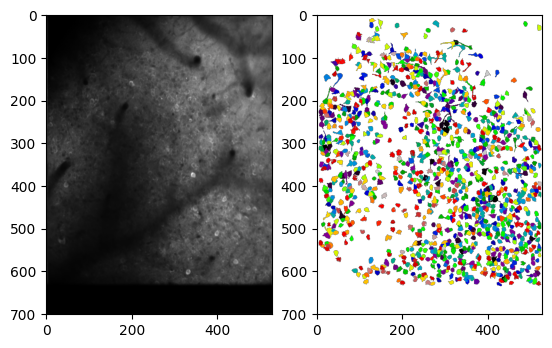

In [5]:
# see ROIs
_, ax = plt.subplots(1, 2)

pix = get_soma_pixel(s2p, color_diff=True)
pix[pix == 0] = np.nan
ax[0].imshow(s2p.image_mean, cmap='grey')
ax[1].imshow(pix, cmap='nipy_spectral')
plt.show()

### Calculate dF/F


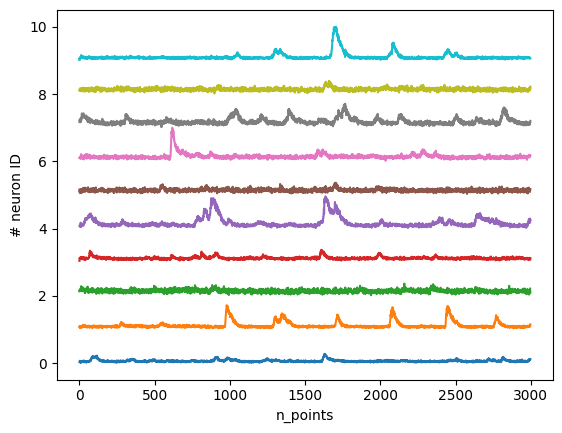

In [6]:
dff = get_neuron_signal(s2p, n=np.arange(10), signal_type='df_f', normalize=True, dff=True, correct_neuropil=True)[0]

# pick the first 100 sec
points = int(100 * s2p.fs)
dff = dff[:, :points]
n_neurons = dff.shape[0]

y = 0
for i in range(n_neurons):
    plt.plot(dff[i] + y)
    y += 1

plt.xlabel('n_points')
plt.ylabel('# neuron ID')
plt.show()

### Calculate deconvolution spikes using OASIS method

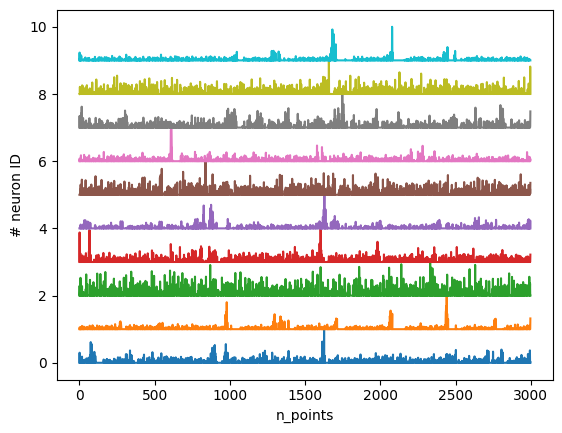

In [7]:
spks = oasis_dcnv(dff, tau=s2p.indicator_tau, fs=s2p.fs)
spks = spks / np.max(spks, axis=1, keepdims=True)
n_neurons = spks.shape[0]

y = 0
for i in range(n_neurons):
    plt.plot(spks[i] + y)
    y += 1

plt.xlabel('n_points')
plt.ylabel('# neuron ID')
plt.show()

### Predict spikes from dF/F using pre-trained model from Cascade

[INFO][25-03-13 11:23:03] - The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30 Hz, with a resampled ground truth that was smoothed with a Gaussian kernelof a standard deviation of 200 ms.

[INFO][25-03-13 11:23:03] - Loaded model was trained at frame rate 30 Hz

[INFO][25-03-13 11:23:03] - Given argument traces contains 10 neurons and 2998 frames.

[INFO][25-03-13 11:23:03] - Noise levels (mean, std; in standard units): 0.46, 0.14


Predictions for noise level 1
	... ensemble 0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/opt/homebrew/Caskroom/miniconda/base/envs/py310/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


	... ensemble 1
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
	... ensemble 2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
	... ensemble 3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
	... ensemble 4
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Predictions for noise level 2
	No neurons for this noise level: 2

Predictions for noise level 3
	No neurons for this noise level: 3

Predictions for noise level 4
	No neurons for this noise level: 4

Predictions for noise level 5
	No neurons for this noise level: 5

Predictions for noise level 6
	No neurons for this noise level: 6

Predictions for noise level 7
	No neurons for this noise level: 7

Predictions for noise level 8
	No neurons for this noise level: 8


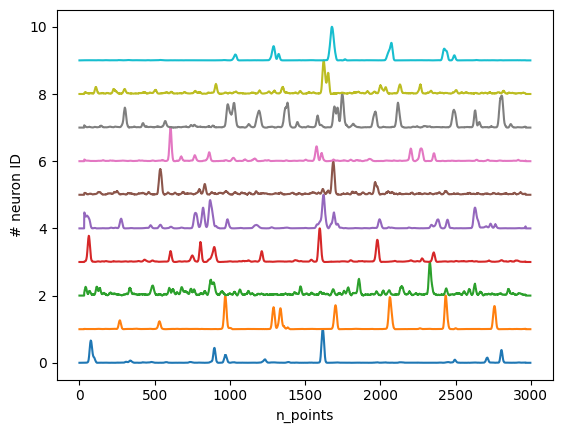

In [8]:
# verbose disable
absl.logging.set_verbosity('error')
logging.getLogger('tensorflow').setLevel(logging.ERROR)

spks = cascade_predict(dff, model_type='Global_EXC_30Hz_smoothing100ms', verbose=False)
spks = spks / np.max(spks, axis=1, keepdims=True)
n_neurons = spks.shape[0]

y = 0
for i in range(n_neurons):
    plt.plot(spks[i] + y)
    y += 1

plt.xlabel('n_points')
plt.ylabel('# neuron ID')
plt.show()